In [1]:
import os
import sys
import argparse
from typing import Tuple
from tensorboardX import SummaryWriter
import copy
import time
import math
import numpy as np
import pickle

# Progressbar
from tqdm import tqdm

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Highlevel from Pytorch
import torch as T
from torch import nn, Tensor
import torch.optim as opt

# Neural Network parts from Pytorch
from torch.nn import TransformerEncoder, TransformerEncoderLayer, init
import torch.nn.functional as F

# Pytorch's Dataset and Dataloader
from torch.utils.data import dataset
from torch.utils.data import DataLoader

# Dataset used
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

# Custom Libraries
import utils
import transformer_modell

device = T.device('cuda' if T.cuda.is_available() else 'cpu')

model = transformer_modell.TransformerModel(33280, 200, 2, 200, 2, 0.2).to(device)

lr        = 5.0  # learning rate
optimizer = T.optim.SGD(model.parameters(), lr=lr)
scheduler = T.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=max(10, 1))

In [49]:
lrs = [5.0]
for _ite in range(20):
    scheduler.load_state_dict(T.load(f"{os.getcwd()}/pruning/{0}/saves/scheduler/sched_{_ite}.pt"))
    lrs.append(np.squeeze(scheduler.state_dict()['_last_lr']))
for _ite in range(20):
    print((lrs[_ite+1]/lrs[_ite]))

0.857375
0.8573749999999999
0.8573749999999999
0.8573749999999999
0.8573749999999998
0.8573749999999998
0.95
1.0
0.95
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.95
1.0
0.95
1.0


In [3]:
print(0.95**3)

0.8573749999999999


In [3]:
# with open(f"{os.getcwd()}/pruning/0/dumps/train_loss/all_train_loss_1.4.dat", "rb") as input_file:
#        all_train_loss_prune = pickle.load(input_file)
#    with open(f"{os.getcwd()}/reintroduction/old_dynamic/0/dumps/train_loss_reint/all_train_loss_1.4.dat", "rb") as input_file:
#        all_train_loss_reint = pickle.load(input_file)

all_val_loss_prune = np.array([])
all_val_loss_reint = np.array([])
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
for _c in comp:
    with open(f"{os.getcwd()}/pruning/0/dumps/validation_loss/all_val_loss_{_c}.dat", "rb") as input_file:
        all_val_loss_prune_temp   = pickle.load(input_file)
    all_val_loss_prune = np.concatenate((all_val_loss_prune, all_val_loss_prune_temp))
with open(f"{os.getcwd()}/reintroduction/old_identical/dumps/reint_summary_plot_data/compression.dat", "rb") as input_file:
    comp_reint = pickle.load(input_file)
for c in comp_reint:
    with open(f"{os.getcwd()}/reintroduction/old_identical/dumps/validation_loss_reint/all_val_loss_{c}.dat", "rb") as input_file:
        all_val_loss_reint_temp   = pickle.load(input_file)
    all_val_loss_reint = np.concatenate((all_val_loss_reint, all_val_loss_reint_temp))

# all_train_loss = np.concatenate((all_train_loss_prune,all_train_loss_reint))
all_val_loss = np.concatenate((all_val_loss_prune,all_val_loss_reint))

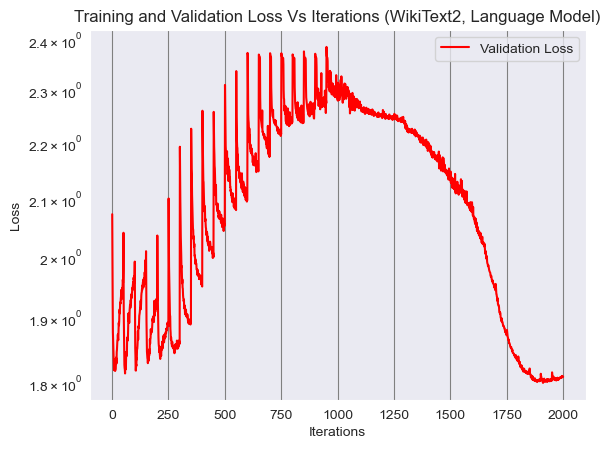

In [4]:
# plt.plot(np.arange(1, 101), all_train_loss, c="blue", label="Training Loss")
plt.plot(np.arange(1, 2001), all_val_loss, c="red", label="Validation Loss")
plt.yscale('log')
plt.title(f"Training and Validation Loss Vs Iterations (WikiText2, Language Model)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.grid(color="gray")

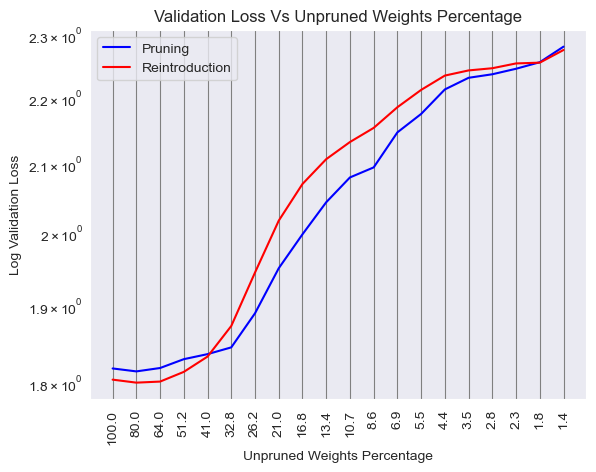

In [6]:
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/best_val.dat", "rb") as input_file:
    best_val = pickle.load(input_file)
with open(f"{os.getcwd()}/reintroduction/old_identical/dumps/reint_summary_plot_data/best_val.dat", "rb") as input_file:
    best_val_reint = pickle.load(input_file)
    best_val_reint = np.flip(best_val_reint)
with open(f"{os.getcwd()}/pruning/0/dumps/summary_plot_data/compression.dat", "rb") as input_file:
    comp = pickle.load(input_file)
a = range(20)
plt.plot(a, best_val, c="blue", label="Pruning")
plt.plot(a, best_val_reint, c="red", label="Reintroduction")
plt.yscale('log')
plt.title(f"Validation Loss Vs Unpruned Weights Percentage")
plt.xlabel("Unpruned Weights Percentage")
plt.ylabel("Log Validation Loss")
plt.xticks(a, comp, rotation="vertical")
plt.legend()
plt.grid(color="gray")